In [1]:
import tensorflow

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib
#import statsmodels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from matplotlib import pyplot
import seaborn as sns
import csv

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#!load_ext nb_black
#!matplotlib inline

In [43]:
DATA_PATH = Path("C:/Users/pavle/Downloads/")

dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

satellite=pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite.timedelta = pd.to_timedelta(satellite.timedelta)
satellite.set_index(["period", "timedelta"], inplace=True)

## DATA EXPLORATION

In [6]:
print("Dst shape: ", dst.shape)
dst.head()

Dst shape:  (139872, 1)


dst
period  timedelta           
train_a 0 days 00:00:00   -7
        0 days 01:00:00  -10
        0 days 02:00:00  -10
        0 days 03:00:00   -6
        0 days 04:00:00   -2

In [7]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

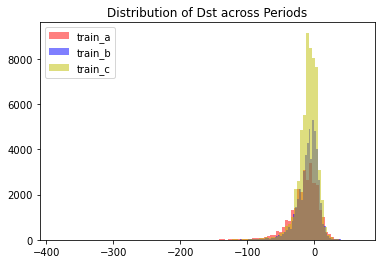

In [8]:
fig, ax = plt.subplots()
colors = ["r", "b", "y"]
for i, period in enumerate(dst.groupby("period")):
    period_name, df = period
    ax.hist(df, alpha=0.5, color=colors[i], bins=100, label=period_name)
plt.legend()
plt.title("Distribution of Dst across Periods")
plt.show()

In [9]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [10]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [11]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [12]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

In [44]:
print("Satellite shape: ", satellite.shape)
satellite.head()

Satellite shape:  (5828, 6)


gse_x_ace  gse_y_ace  gse_z_ace  gse_x_dscovr  \
period  timedelta                                                  
train_a 0 days     1522376.9   143704.6   149496.7           NaN   
        1 days     1525410.9   136108.8   151034.1           NaN   
        2 days     1528484.9   128470.5   152387.7           NaN   
        3 days     1531570.3   120818.4   153561.4           NaN   
        4 days     1534633.1   113178.5   154534.6           NaN   

                   gse_y_dscovr  gse_z_dscovr  
period  timedelta                              
train_a 0 days              NaN           NaN  
        1 days              NaN           NaN  
        2 days              NaN           NaN  
        3 days              NaN           NaN  
        4 days              NaN           NaN

In [47]:
satellite= satellite.drop(['gse_x_dscovr','gse_y_dscovr','gse_z_dscovr'], axis=1)

In [48]:
satellite.head()

gse_x_ace  gse_y_ace  gse_z_ace
period  timedelta                                 
train_a 0 days     1522376.9   143704.6   149496.7
        1 days     1525410.9   136108.8   151034.1
        2 days     1528484.9   128470.5   152387.7
        3 days     1531570.3   120818.4   153561.4
        4 days     1534633.1   113178.5   154534.6

In [49]:
print("Satellite shape: ", satellite.shape)
satellite.head()

Satellite shape:  (5828, 3)


gse_x_ace  gse_y_ace  gse_z_ace
period  timedelta                                 
train_a 0 days     1522376.9   143704.6   149496.7
        1 days     1525410.9   136108.8   151034.1
        2 days     1528484.9   128470.5   152387.7
        3 days     1531570.3   120818.4   153561.4
        4 days     1534633.1   113178.5   154534.6

In [50]:
satellite.groupby("period").describe().T

period                train_a       train_b       train_c
gse_x_ace count  1.201000e+03  2.191000e+03  2.436000e+03
          mean   1.485290e+06  1.487840e+06  1.486385e+06
          std    5.607983e+04  5.994603e+04  5.983284e+04
          min    1.388193e+06  1.383933e+06  1.386258e+06
          25%    1.433771e+06  1.431776e+06  1.437011e+06
          50%    1.481785e+06  1.486116e+06  1.484200e+06
          75%    1.535496e+06  1.540465e+06  1.541704e+06
          max    1.592525e+06  1.594075e+06  1.590599e+06
gse_y_ace count  1.201000e+03  2.191000e+03  2.436000e+03
          mean  -4.480147e+03  1.571215e+03 -2.248710e+03
          std    1.744672e+05  1.802309e+05  1.808384e+05
          min   -2.524958e+05 -2.620650e+05 -2.669124e+05
          25%   -1.772713e+05 -1.773523e+05 -1.825770e+05
          50%   -7.751000e+03  1.288800e+03 -3.188950e+03
          75%    1.684129e+05  1.816189e+05  1.771006e+05
          max    2.607130e+05  2.646418e+05  2.670576e+05
gse_z_ace count  1.201000e+03  2.191000e+03  2.436000e+03
          mean   4.441772e+03  7.822374e+03 -5.227775e+03
          std    1.070658e+05  1.079299e+05  1.062034e+05
          min   -1.524593e+05 -1.507659e+05 -1.615415e+05
          25%   -1.025815e+05 -9.997735e+04 -1.109266e+05
          50%    3.303400e+03  1.044840e+04 -6.292550e+03
          75%    1.119031e+05  1.159231e+05  1.011548e+05
          max    1.571437e+05  1.640614e+05  1.512611e+05

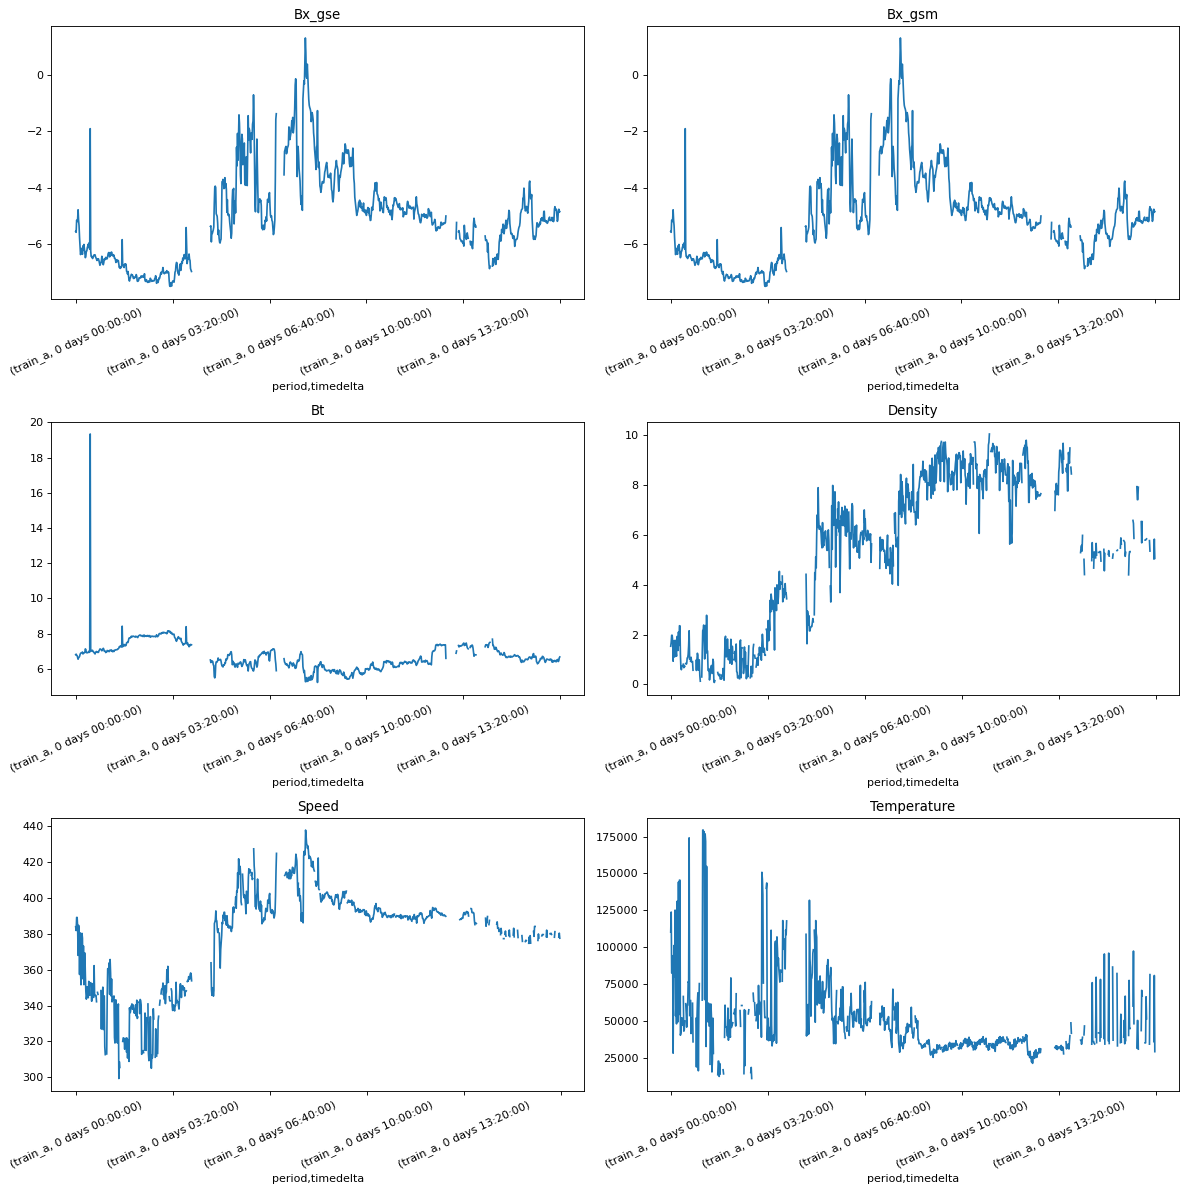

In [13]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [14]:
solar_wind.isna().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

In [51]:
satellite.isna().sum()

gse_x_ace    0
gse_y_ace    0
gse_z_ace    0
dtype: int64

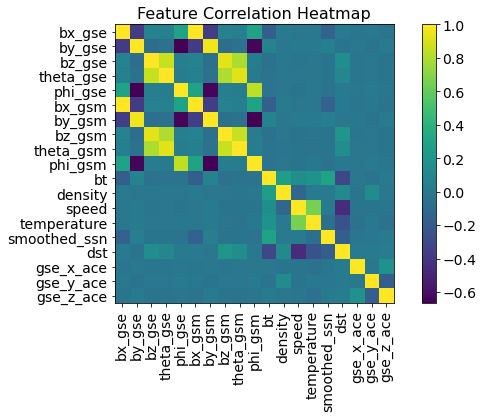

In [52]:
corr = solar_wind.join(sunspots).join(dst).join(satellite).fillna(method="ffill").corr()

plt.figure(figsize=(10, 5))
plt.matshow(corr, fignum=1)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

## FEATURE GENERATION

In [53]:
import tensorflow
from numpy.random import seed
from tensorflow import random
seed(2020)
tensorflow.random.set_seed(2021)

In [57]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots,scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [58]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [59]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [60]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift(-1)
    y["t1"] = y.groupby("period").dst.shift(-2)
    return y[YCOLS]


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                  
train_a 0 days 00:00:00 -10.0 -10.0
        0 days 01:00:00 -10.0  -6.0
        0 days 02:00:00  -6.0  -2.0
        0 days 03:00:00  -2.0   3.0
        0 days 04:00:00   3.0   5.0

In [61]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

## SPLITTING THE DATA

In [62]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

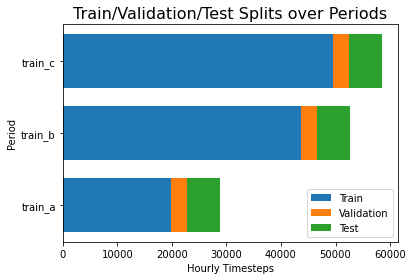

In [63]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

In [64]:
print(train.shape)
train.head()

(112872, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [65]:
print(test.shape)
test.head()

(18000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 951 days 00:00:00 -9.0 -9.0 -0.750759  0.234958         -0.321374   
        951 days 01:00:00 -9.0 -6.0 -0.791318  0.284752         -0.319784   
        951 days 02:00:00 -6.0 -7.0 -0.980331  0.573975         -0.257948   
        951 days 03:00:00 -7.0 -7.0 -1.043536 -0.412378         -0.209809   
        951 days 04:00:00 -7.0 -9.0 -0.993770 -0.603035         -0.189010   

                           temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                     
train_a 951 days 00:00:00        -0.263304     0.437479   -0.443221   
        951 days 01:00:00        -0.301259     0.321370    0.422124   
        951 days 02:00:00        -0.344924     0.530721    0.818555   
        951 days 03:00:00        -0.397676     0.753977   -0.432534   
        951 days 04:00:00        -0.402766     0.789420   -0.391195   

                           by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                             
train_a 951 days 00:00:00    -0.202748    0.318096     0.849393   -0.020478   
        951 days 01:00:00    -0.240443    0.166232     0.776471   -0.220270   
        951 days 02:00:00    -0.137579    0.157993     0.147218   -0.276363   
        951 days 03:00:00    -0.157578   -0.430909     0.121454   -0.282263   
        951 days 04:00:00    -0.252788   -0.372368    -0.149991   -0.510691   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 951 days 00:00:00   -0.145924  -0.503193     -0.407614    -0.315154   
        951 days 01:00:00   -0.127991  -0.084971     -0.427620    -0.198320   
        951 days 02:00:00   -0.120626  -0.310757     -0.435274    -0.374498   
        951 days 03:00:00   -0.180313  -0.531222     -0.414209    -0.365694   
        951 days 04:00:00   -0.219717  -0.649039     -0.437909    -0.267683   

                           smoothed_ssn  
period  timedelta                        
train_a 951 days 00:00:00      2.113449  
        951 days 01:00:00      2.113449  
        951 days 02:00:00      2.113449  
        951 days 03:00:00      2.113449  
        951 days 04:00:00      2.113449

In [66]:
print(val.shape)
val.head()

(9000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 826 days 00:00:00  8.0  8.0  0.947600 -0.229038         -0.473006   
        826 days 01:00:00  8.0  9.0  0.464361  0.276422          0.316358   
        826 days 02:00:00  9.0  8.0  0.273709  0.197794          0.073052   
        826 days 03:00:00  8.0  8.0  0.078250  0.445950          0.290167   
        826 days 04:00:00  8.0  8.0 -0.172001  0.071668          0.336941   

                           temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                     
train_a 826 days 00:00:00        -0.372466    -1.575773   -0.882804   
        826 days 01:00:00         0.379133    -1.614668   -0.280527   
        826 days 02:00:00         0.302776    -1.130185    0.809654   
        826 days 03:00:00         0.460514    -0.943295    1.891776   
        826 days 04:00:00         0.437184    -0.771915    0.408708   

                           by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                             
train_a 826 days 00:00:00     0.097349    1.132243     1.867509   -0.274071   
        826 days 01:00:00     0.397057    0.655653     0.530847    0.238450   
        826 days 02:00:00     0.320615    0.122597    -1.297872   -0.367564   
        826 days 03:00:00    -0.062777   -0.024515    -0.681155    1.253984   
        826 days 04:00:00     0.332551   -0.049795    -0.704262    1.021870   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 826 days 00:00:00   -0.323757  -0.527592      0.392352    -0.296261   
        826 days 01:00:00   -0.155733   0.142157      0.022523    -0.150077   
        826 days 02:00:00   -0.072557   0.563556     -0.200011    -0.089490   
        826 days 03:00:00   -0.001116   0.127350      0.135548     0.048349   
        826 days 04:00:00    0.063829   0.143625     -0.027986    -0.066235   

                           smoothed_ssn  
period  timedelta                        
train_a 826 days 00:00:00      2.191722  
        826 days 01:00:00      2.191722  
        826 days 02:00:00      2.191722  
        826 days 03:00:00      2.191722  
        826 days 04:00:00      2.191722

## BUILDING OUR MODEL

In [67]:
import keras
from keras import preprocessing


data_config = {
    "timesteps": 32,
    "batch_size": 32,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3523
Number of val batches: 276


In [68]:

print(tensorflow.__version__)

2.3.0


## DESIGNING AN LSTM

In [69]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

# define our model
model_config = {"n_epochs": 32, "n_neurons": 512, "dropout": 0.2, "stateful": False, "activation":"tanh",
                "recurrent_activation": "sigmoid", "recurrent_dropout": 0, "unroll": False,"use_bias":True}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # usually set to (`batch_size`, `sequence_length`, `n_features`)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],activation=model_config["activation"],
        recurrent_activation=model_config["recurrent_activation"],
        recurrent_dropout=model_config["recurrent_dropout"],unroll=model_config["unroll"],
        use_bias=model_config["use_bias"]
    )
)
model.add(Dense(len(YCOLS)))
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 512)               1081344   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 1,082,370
Trainable params: 1,082,370
Non-trainable params: 0
_________________________________________________________________


In [70]:
print(np.__version__)

1.19.1


In [71]:
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=0,
    shuffle=False,
    validation_data=val_ds,
)

## EVALUATION

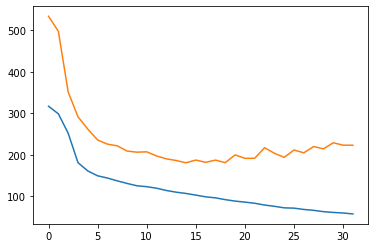

In [72]:
for name, values in history.history.items():
    plt.plot(values)

In [75]:
model

In [76]:
model.optimizer.get_weights()

[112736,
 array([[ 0.02451695,  0.01310639,  0.04936383, ..., -0.00563147,
          0.0032481 ,  0.0028958 ],
        [ 0.0061508 ,  0.01355099, -0.00566845, ..., -0.00120578,
          0.00245059, -0.00205793],
        [-0.01024771, -0.00422473, -0.01388475, ...,  0.00480563,
          0.00308933, -0.00557756],
        ...,
        [-0.02042465,  0.01134073, -0.01535361, ...,  0.00128579,
         -0.0070027 , -0.0030542 ],
        [ 0.0120358 ,  0.00784806,  0.03149818, ...,  0.00053636,
         -0.00022183, -0.00068015],
        [ 0.0211322 ,  0.014705  ,  0.08868328, ...,  0.00460327,
          0.01311892, -0.00712391]], dtype=float32),
 array([[-2.0582243e-03,  2.0164833e-04, -5.4545416e-03, ...,
         -1.5324602e-04, -8.0922589e-05, -1.6868711e-04],
        [ 1.0596167e-03,  5.9381803e-04, -3.8293979e-04, ...,
         -1.3841428e-04, -3.0694483e-04,  2.8510072e-04],
        [ 2.1938602e-03, -8.7619602e-04, -2.2425923e-02, ...,
          2.2043953e-04, -1.4113642e-03, -2.531

In [77]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])

In [78]:
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.2f}")

558/558 [==============================] - 53s 95ms/step - loss: 190.7850
Test RMSE: 13.81


In [80]:
import pickle
import json
model.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

INFO:tensorflow:Assets written to: model\assets
{'timesteps': 32, 'batch_size': 32, 'solar_wind_subset': ['bt', 'temperature', 'bx_gse', 'by_gse', 'bz_gse', 'speed', 'density']}
